# Statistiques Descriptives simples

**L'objectif de cette partie est d'analyser la base de données à la réception de cette dernière. Voici les principales questions auxquelles nous souhaitons apporter des réponses :**
- **Quelles sont les catégories les plus représentées ?**
- **Comment les festivals se répartissent suivant leur localisation (est ce que certains types de festivals sont plus présents dans certaines parties de la France) ?**
- **Comment les festivals se répartissent suivant leur date (par ex. est ce que les festivals de musiques sont plus présents en été, avec une possible explication qu'ils se déroulent en extérieur ?) ?**


### 0. Prérequis

In [2]:
import s3fs
import pandas as pd

# Configuration du bucket et du chemin du fichier
MY_BUCKET = "arthurneau"  # Remplace par le nom de ton bucket
FILE_PATH_S3 = f"{MY_BUCKET}/diffusion/festivals_en_France (1).csv"  # Chemin complet sur MinIO

# Initialisation de la connexion à MinIO
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

# Importer le fichier CSV depuis MinIO
with fs.open(FILE_PATH_S3, "r") as file_in:
    df = pd.read_csv(file_in, sep=';', encoding='utf-8-sig')

# Afficher les premières lignes
print(df.head())  # Afficher les 5 premières lignes

           ﻿Nom du festival Envergure territoriale  \
0          Festival andalou              Régionale   
1  Festival Rêves d'enfants                    NaN   
2      Printemps de Paroles                    NaN   
3                 Pharaonic                    NaN   
4           Sarcus Festival                    NaN   

  Région principale de déroulement Département principal de déroulement  \
0       Provence-Alpes-Côte d'Azur                             Vaucluse   
1       Provence-Alpes-Côte d'Azur                         Hautes-Alpes   
2                    Île-de-France                       Seine-et-Marne   
3             Auvergne-Rhône-Alpes                               Savoie   
4              Centre-Val de Loire                       Indre-et-Loire   

  Commune principale de déroulement  \
0                           Avignon   
1                          Briançon   
2                Bussy-Saint-Martin   
3                          Chambéry   
4              Chemillé-sur-I

In [10]:
import subprocess
import sys

# Fonction pour installer les packages nécessaires
def install_packages():
    packages = [
        "pandas",
        "geopandas",
        "matplotlib",
        "cartiflette"
    ]
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} installé avec succès.")
        except subprocess.CalledProcessError:
            print(f"Erreur lors de l'installation de {package}.")

# Appeler la fonction pour installer les packages
if __name__ == "__main__":
    install_packages()


pandas installé avec succès.
geopandas installé avec succès.
matplotlib installé avec succès.
cartiflette installé avec succès.


## I. Catégories les plus représentées 

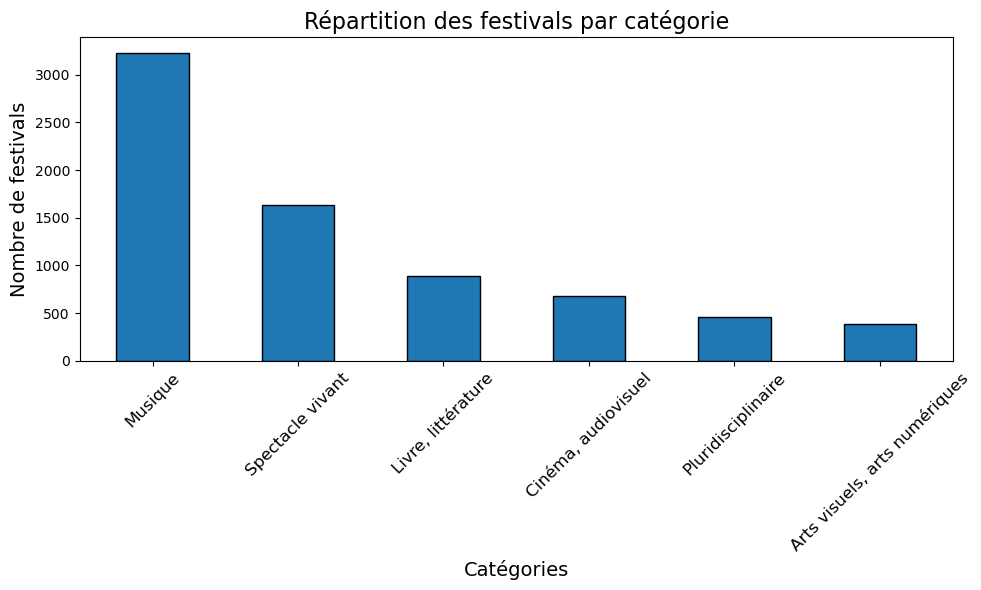

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Remplacer les valeurs vides par 'vide'
df['Discipline dominante'] = df['Discipline dominante'].fillna('vide')

# 2. Compter les occurrences de chaque catégorie
category_counts = df['Discipline dominante'].value_counts()

# 3. Créer l'histogramme
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', edgecolor='black')
plt.title("Répartition des festivals par catégorie", fontsize=16)
plt.xlabel("Catégories", fontsize=14)
plt.ylabel("Nombre de festivals", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Afficher l'histogramme
plt.show()


### Analyse : ###
On remarque alors que la catégorie la plus représentée est la Musique, très largement devant les autres, avec plus de 3000 festivals. On s'intéressera alors dans la 2ème partie de l'analyse statistique à la confrontation de ces festivals avec les plus importants festivals de musiques en France (top 10 voire top 50). 
<br> La répartition correspond bien à nos attentes, à savoir l'importance relative de la musique par rapport aux autres festivals, mais suivit par les spectacles vivants, et le livre.
<br> ⚠️ Attention tout de même aux données représentées ici, qui ne correspondent pas aux données utilisées in fine, car nous supprimons certains festivals là où les colonnes qui sont nécessaires à notre moteur de recherche ne sont pas complètes.

## II. Répartition géographique

On choisit une représentation sur une carte de France, suivant les départements et les régions.

### II.1. Répartition par régions

/tmp/ipykernel_274256/1760013273.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


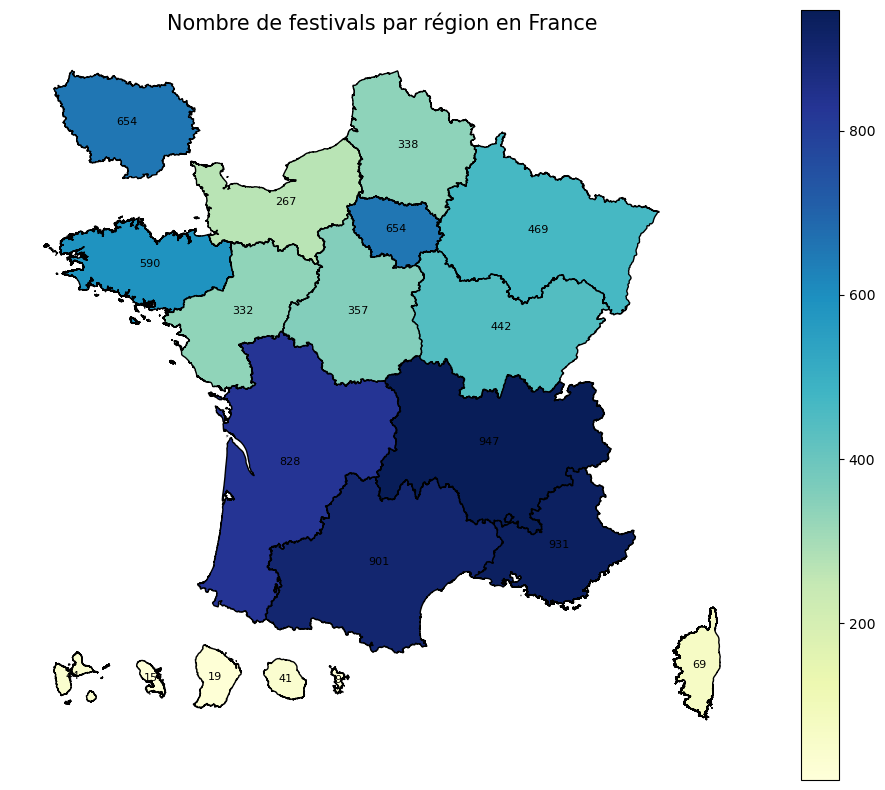

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Filtrer les données avec des régions valides
df_region = df.dropna(subset=["Région principale de déroulement"])

# Compter les festivals par région
region_counts = df_region['Région principale de déroulement'].value_counts().reset_index()
region_counts.columns = ['region', 'count']

# Récupérer les contours des régions
regions = carti_download(
    values="France",
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Joindre les données des festivals aux régions
regions = regions.merge(region_counts, left_on="LIBELLE_REGION", right_on="region", how="left")

# Remplacer les NaN par 0 (pour les régions sans festivals)
regions['count'] = regions['count'].fillna(0)

# Créer une carte des festivals par région
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
regions.plot(column="count", cmap="YlGnBu", legend=True, ax=ax, edgecolor="black")

# Ajouter les nombres de festivals sur la carte
for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):
    ax.text(x, y, str(int(label)), fontsize=8, ha='center', va='center', color='black')

# Ajouter le titre
plt.title("Nombre de festivals par région en France", fontsize=15)
plt.axis('off')  # Désactiver les axes
plt.show()


### II.2. Répartition par départements

/tmp/ipykernel_274256/1712828113.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, departments['count']):


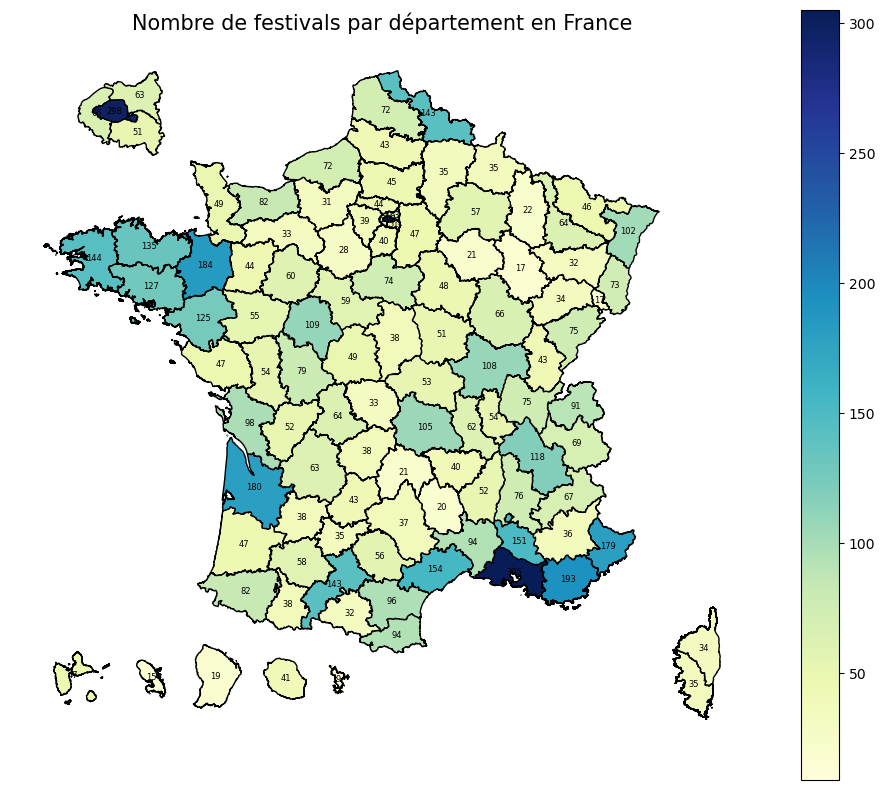

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download


# Filtrer les données avec des départements valides
df_department = df.dropna(subset=["Département principal de déroulement"])

# Compter les festivals par département
department_counts = df_department['Département principal de déroulement'].value_counts().reset_index()
department_counts.columns = ['department', 'count']

# Récupérer les contours des départements
departments = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Joindre les données des festivals aux départements
departments = departments.merge(department_counts, left_on="LIBELLE_DEPARTEMENT", right_on="department", how="left")

# Remplacer les NaN par 0 (pour les départements sans festivals)
departments['count'] = departments['count'].fillna(0)

# Créer une carte des festivals par département
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
departments.plot(column="count", cmap="YlGnBu", legend=True, ax=ax, edgecolor="black")

# Ajouter les nombres de festivals sur la carte
for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, departments['count']):
    ax.text(x, y, str(int(label)), fontsize=6, ha='center', va='center', color='black')

# Ajouter le titre
plt.title("Nombre de festivals par département en France", fontsize=15)
plt.axis('off')  # Désactiver les axes
plt.show()
